<img src="img/SubGradientDescent_Thumbnail2.png" alt="Thumbnail of the subgradient descent article on Machine Learning Compass" width="720"/>

# Subgradients and Subgradient Descent
#### Last edited: 22 Aug 2021
This is the accompanying notebook for [this](https://machinelearningcompass.com/machine_learning_math/subgradient_descent/) article of [Machine Learning Compass](https://machinelearningcompass.com). 

---

## Imports and helper functions

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# from the gradient descent for linear regression article
def create_function(theta):
    def f(X_b):
        return np.dot(X_b,theta)
    
    return f

# from the gradient descent for linear regression article
def add_intercept_ones(X):
    intercept_ones = np.ones((len(X),1)) # results in array( [ [1],..,[1] ] )
    X_b = np.c_[intercept_ones,X]
    return X_b

# from the standardization article
def standardize(X_train, X_test):
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_train_s = (X_train - mean) / std 
    X_test_s = (X_test - mean) / std 
    return X_train_s, X_test_s, mean, std

## The dataset

We have a dataset of figures. For each figure, we know it's age (x) as well as it's price (y).
The dataset looks like this:

In [20]:
X = np.array([1.25, 1.  , 0.75, 1.5, 1.75, 1.5 , 0.75])
y = np.array([40. , 42. , 46. , 37., 40. , 38. , 39.8])

X_train, X_test = X[:4], X[4:]
y_train, y_test = y[:4], y[4:]

X_train_s, X_test_s, _, _ = standardize(X_train, X_test)

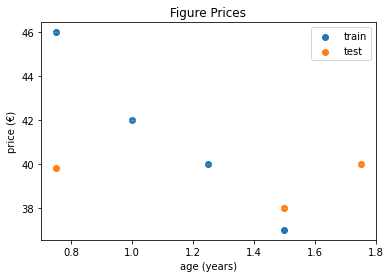

In [21]:
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_test, y_test, label="test")
plt.xlabel("age (years)")
plt.ylabel("price (€)")
plt.title("Figure Prices")
plt.grid(color = 'white', alpha=0.5, linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

We now want to create a linear model to predict the price of previously unseen figures given their age.
For this, we will use lasso regression.
There is just one problem
The L1-penalty, $||\boldsymbol{\theta}||_1 = \sum_{i=1}^n{|\theta_i|}$ is not differentiable at 0.
But to solve our lasso model, we have to compute the gradient of our lasso loss function,
which includes an L1-penalty. So what do we do? We use subgradients!

## Subgradients

Subgradients can be interpreted as "intermediate" vectors around regular gradients.
A subgradient $g$ of a function $f$ at a point $x$ is exactly the regular gradient when the $f$
is differentiable at $x$. Otherwise, a subgradient of $f$ at $x$ is defined as:

$$
\text{A vector } g \in \mathbb{R}^d \text{ is a subgradient of a function } \\
f: \mathbb{R}^d \rightarrow \mathbb{R} \text{ at the point } x \text{ if for all points } z \text{ the following holds:} \\
f(z) \geq f(x) + g^T(z - x)
$$

There can be zero, one, or any number of subgradients of a function $f$ at a non-differentiable point $x$.

Now, instead of computing the regular gradient of our L1-penalty, which would be problematic, we instead
compute the subgradient. The subgradient will be identic to the regular gradient at every point except 0,
and it will be 0 at the point 0.
In other terms, the (or rather, one valid) subgradient for the L1-penalty is:

$$
\stackrel{sub}{\nabla} _g(x) = \left \{
  \begin{aligned}
    &1 && \text{if}\ x>0 \\
    &\color{#26a6ed}{x \in [-1,1]} && \color{#26a6ed}{\text{if}\ x=0} \\
    &-1 && \text{if}\ x<0
  \end{aligned} \right.
$$

Now let's implement subgradient descent!

## Loss and gradient functions

Before implementing subgradient descent, we'll have to implement functions that compute our loss as well as our gradient. Since these functions have parameters themselves, like `a1` or `a2`, we will use wrapper functions that take in these higher-level parameters and return functions that utilize those same parameters.

In [22]:
def get_elastic_mse_function(a2=1, a1=0):
    
    def elastic_mse(y, y_predicted, theta):
        error = y-y_predicted
        loss = 1/(y.size) * np.dot(error.T, error) + a2 * np.dot(theta,theta) + a1 * np.sum(np.abs(theta))
        return loss
    
    return elastic_mse


def get_elastic_gradient_function(a2=1, a1=0):
    
    def elastic_gradient(X_b, y, y_pred, theta):
        return  -(2/y.size) * X_b.T.dot((y - y_pred)) + a1 * np.sign(theta) + 2 * a2 * theta

    return elastic_gradient

## Subgradient descent

Now we can go ahead and implement subgradient descent. It is almost identical to regular gradient descent,
in fact the only difference is the usage of a subgradient instead of a regular gradient.

In [23]:
def subgradient_descent(X, y, theta, criterion, subgradient_function, number_of_iterations, learning_rate):
    X_b = add_intercept_ones(X)
    for i in range(number_of_iterations):

        # predict and calculate loss
        f = create_function(theta) # create the current function
        y_predicted = f(X_b) # predict our entire x
        loss = criterion(y, y_predicted, theta) # calculate the error

        # perform optimization
        subgradient = subgradient_function(X_b, y, y_predicted, theta) # calculate gradient
        theta = theta - learning_rate * subgradient #adjust m and b
        
    return theta

Let's try it out on our dataset!

In [24]:
theta = np.random.rand(2)
number_of_iterations = 3000
learning_rate = 0.01

# important: use standardized data!
theta_lasso_subgd = subgradient_descent(X_train_s, y_train, theta,
                    get_elastic_mse_function(a2=0, a1=1),
                    get_elastic_gradient_function(a2=0, a1=1),
                    number_of_iterations, learning_rate)
print(theta_lasso_subgd)

[40.75       -2.74229857]


Nice!

### Comparing subgradient descent for lasso to sklearn's Lasso

Let's compare our own implementation to the one from sklearn to make sure our code is doing what it is supposed to do

In [25]:
from sklearn.linear_model import Lasso

In [26]:
lasso_sklearn = Lasso()
# sklearn expects X to be a 2D-array, so we expand the dimensionality of our X
# by using numpys "expand_dims"-command
# Again, use standardized data!
lasso_sklearn.fit(np.expand_dims(X_train_s,1), y_train)

print(lasso_sklearn.intercept_, lasso_sklearn.coef_[0])

41.25 -2.242298567374695


The parameters are very close to our own implementation, so that is a good sign!
Scikit-learn uses coordinate descent instead of gradient descent, so that explains most of the fluctuations.

Let's plot the two models!

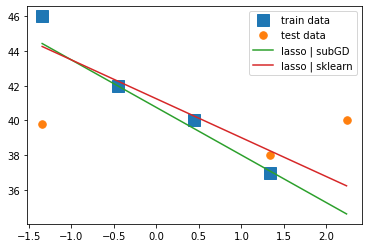

In [27]:
X_s = np.concatenate([X_train_s, X_test_s])

X_interval = np.array([min(X_s), max(X_s)]) # we'll use these points to plot our linear functions

plt.plot(X_train_s, y_train, "s", markersize=12, label="train data")
plt.plot(X_test_s, y_test, ".", markersize=15, label="test data")

plt.plot()
plt.plot(X_interval, add_intercept_ones(X_interval).dot(theta_lasso_subgd), label="lasso | subGD")
plt.plot(X_interval, lasso_sklearn.predict(np.expand_dims(X_interval,1)), label="lasso | sklearn")
plt.grid(color = 'white', alpha=0.5, linestyle = '--', linewidth = 0.5)
plt.legend()

Nice, the two models look extremely similar.

### Comparing subgradient descent for lasso to linear regression (OLS regression)

Let's also compare our lasso implementation to regular linear regression.
Our lasso model should have smaller model parameters because of the regularization term.

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
linreg_sklearn = LinearRegression()
# here we technically don't need to use the standardized data,
# but since we're comparing different models it makes sense
# to use the same dataset
linreg_sklearn.fit(np.expand_dims(X_train_s,1), y_train)

print("Lasso:", theta_lasso_subgd)
print("OLS:", linreg_sklearn.intercept_, linreg_sklearn.coef_[0])

Lasso: [40.75       -2.74229857]
OLS: 41.25 -3.2422985673746965


Ok, the lasso coefficients are a bit smaller, so our model is working as intended.
Let's plot both models again:

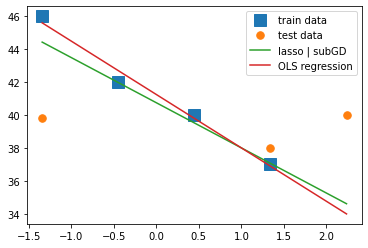

In [30]:
X_interval = np.array([min(X_s), max(X_s)]) # we'll use these points to plot our linear functions

plt.plot(X_train_s, y_train, "s", markersize=12, label="train data")
plt.plot(X_test_s, y_test, ".", markersize=15, label="test data")

plt.plot()
plt.plot(X_interval, add_intercept_ones(X_interval).dot(theta_lasso_subgd), label="lasso | subGD")
plt.plot(X_interval, linreg_sklearn.predict(np.expand_dims(X_interval,1)), label="OLS regression")
plt.grid(color = 'white', alpha=0.5, linestyle = '--', linewidth = 0.5)
plt.legend()

Nice! The difference in this example is not gigantic, but it is there and if we wanted to,
we could increase it by increasing the regularization parameter $\alpha$.

## The Fatal Flaw

One key property of lasso is that unnecessary weights can be set all the way to zero. In other words, lasso produces sparse model parameters. To make sure our implementation fulfills this property, we can perform a simple test. We create a completely random X, a completely random y, and then we run lasso on it. Ideally, every single parameter should be set to zero because there should be no correlation between our X and our y.

In [31]:
# This supresses the scientific notation in NumPy; purely cosmetic change
np.set_printoptions(suppress=True)

In [32]:
theta_rand = np.random.rand(51)
X_rand = np.random.rand(100,50)
y_rand = np.random.rand(100)
theta_rand_lasso_subgd = subgradient_descent(X_rand, y_rand, theta_rand,
                                     get_elastic_mse_function(a2=0, a1=1),
                                     get_elastic_gradient_function(a2=0, a1=1),
                                     3000, 0.01)
print(theta_rand_lasso_subgd)

[ 0.01097733  0.00863645 -0.00334322 -0.00077015  0.01362579  0.00275809
  0.00640909  0.00479857 -0.00547198 -0.0012228  -0.00524975 -0.00220924
  0.00303529  0.01206145  0.01108581  0.01207869 -0.00127852  0.00857761
  0.01004202 -0.00096981  0.00772184  0.00385904 -0.0036469   0.00154202
  0.00661548  0.00910058  0.00223111  0.00910211  0.00363602 -0.00376783
  0.00083303  0.01249276 -0.00349888 -0.00257467  0.00327662  0.01169476
  0.0033354   0.00619069  0.00066409 -0.00149209 -0.00581543 -0.00353936
  0.00775194 -0.00140955  0.00929266  0.00065507 -0.00560598 -0.00114546
 -0.00520523  0.00921451  0.00344596]


As we see, our implementation does not zero out any of the weights. Why is this?
The most common answer I found to this question was that this is because subgradients are approximations and thus naturally imprecise.
However, we can debunk this question by looking at the number of times our subgradient is computed at 0 because this is the only point at which our subgradient differs from the regular gradient.

If you want to try this out for yourself, take a look at the second programming exercise in [this](https://machinelearningcompass.com/machine_learning_math/subgradient_descent/) article of Machine Learning Compass. 

There you will see that this point is indeed never hit during subgradient descent.
Why? This point can only be hit when the L1-penalty is 0, and the L1-penalty is only zero if all of the values of $\boldsymbol{\theta}$ are 0 as well. Since this very rarely ever happens, this point is not hit.

### The Fatal Flaw of...?

So if our subgradient is not the problem, what is?
Let's look at the evolution of our parameter vector $\boldsymbol{\theta}$ over time.

For this we will modify our `subgradient_descent`-function to not only return the optimized $\boldsymbol{\theta}$ but also the value of $\boldsymbol{\theta}$ for every epoch. In addition,
we will use a learning rate schedule to gradually decrease the learning rate of our algorithm in later epochs. We will use a random dataset with only two features to ease visualization.

In [33]:
def subgradient_descent(X, y, theta, criterion, subgradient_function, number_of_iterations, learning_rate):
    X_b = add_intercept_ones(X)
    theta_hist = []
    for i in range(1, number_of_iterations+1):
        if i > 20:
            learning_rate = 1 / (4 * i)

        # predict and calculate loss
        f = create_function(theta) # create the current function
        y_predicted = f(X_b) # predict our entire x
        loss = criterion(y, y_predicted, theta) # calculate the error

        # perform optimization
        subgradient = subgradient_function(X_b, y, y_predicted, theta) # calculate gradient
        theta = theta - learning_rate * subgradient #adjust m and b
        theta_hist.append(theta)
        
    return theta, theta_hist

Here's the random dataset:

In [34]:
load_dataset = True
if load_dataset:
    X_rand = np.load("./data/X_rand.np.npy")
    y_rand = np.load("./data/y_rand.np.npy")
    theta_rand = np.load("./data/theta_rand.np.npy")
else:
    np.random.seed(42)
    theta_rand = np.random.rand(2)
    X_rand = np.random.rand(100,1)
    y_rand = np.random.rand(100)

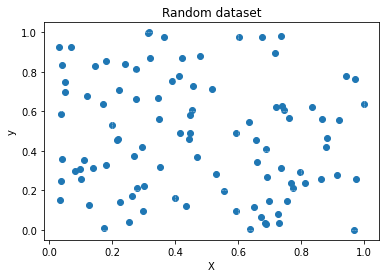

In [35]:
plt.scatter(X_rand, y_rand)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Random dataset")
plt.grid(color = 'white', alpha=0.6, linestyle = '--', linewidth = 0.5)
plt.show()

In [36]:
theta_rand_optimized, theta_rand_hist = subgradient_descent(X_rand, y_rand, theta_rand,
                                     get_elastic_mse_function(a2=0, a1=1),
                                     get_elastic_gradient_function(a2=0, a1=1),
                                     1000, 0.01)
theta_rand_hist = np.array(theta_rand_hist)

Here's the final visualization of `theta_rand_hist`:

![Subgradient Descent Convergence](img/subgradient_convergence.webp)

So far this looks rather smooth, right?
The blue x is the point (0,0),
which should be the optimal theta for our lasso model,
under the assumption that the dataset really does not have any meaningful correlations.
(Sub)gradient descent seems to find this minium rather well.

Here's the code used to generate the above visualization:

In [37]:
import matplotlib.patheffects as pe

In [38]:
# Note: Running this cell will store a lot of files
# to run this cell, change the above to "if True"
if False:
    for i in range(len(theta_rand_hist)):
        if i < 100 or (i < 1000 and i % 50 == 0):

            plt.contourf(w_1t, w_2t, z, levels=500)#, cmap=plt.cm.jet)
            cont = plt.contour(w_1t, w_2t, z, levels=10, colors='white')
            plt.clabel(cont, inline=1)
            plt.scatter([0],[0], marker="x", color="cyan", s=150, zorder=100)
            plt.plot(theta_rand_hist[:,0][:i], theta_rand_hist[:,1][:i], color="red", marker="x")
            plt.annotate(
                f"iteration {i}",
                xy=(theta_rand_hist[i,0], theta_rand_hist[i,1]),
                xytext=(theta_rand_hist[i,0], theta_rand_hist[i,1] + 0.1),
                ha="center",
                arrowprops=dict(facecolor="black", shrink=0.1),
                color="white",
                fontsize="14",
                zorder=10000,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")]
            )
            plt.savefig(f"./anim/subgd_frame_{i}.png")
            plt.close()

Let's zoom in a bit further to see what's really going on.

Here's the final visualization:

![Zooming into (sub)gradient descent](img/subgradient_descent_zoom.webp)

As we can see, if we zoom in *reaally* strongly,
we do see that (sub)gradient descent does indeed not find the exact optimal point (0,0),
and instead jumps around in it's immediate neighborhood.
After all, gradient descent is still just an approximation.

Here's the code to generate the frames for the above visualization:

In [39]:
# Note: running this cell will store a lot of files
# to run this cell, change the above to "if True"

if False:
    # this is needed to further divide the zoom transition at the very end, because the numbers get so small
    scale_constants = [0.9, 0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.004, 0.003, 0.002, 0.001, 0.00075, 0.0005, 0.00025]
    num_zoom_indices = len(zoomLevelsXMin) - 1 
    last_fixed_zoom_idx = num_zoom_indices - 1

    for i in range(len(zoomLevelsXMin) + len(cs) - 1):

            plt.contourf(w_1t, w_2t, z, levels=500)#, cmap=plt.cm.jet)
            cont = plt.contour(w_1t, w_2t, z, levels=10, colors='white')
            plt.clabel(cont, inline=1)
            plt.scatter([0],[0], marker="x", color="cyan", s=150, zorder=100)
            plt.plot(theta_rand_hist[:,0], theta_rand_hist[:,1], color="red", marker="x")

            if i < 49:
                plt.xlim(zoomLevelsXMin[i], zoomLevelsXMax[i])
                plt.ylim(zoomLevelsYMin[i], zoomLevelsYMax[i])
            else:
                plt.xlim(zoomLevelsXMin[last_fixed_zoom_idx] * scale_constants[i - num_zoom_indices], zoomLevelsXMax[last_fixed_zoom_idx] * cs[i - num_zoom_indices])
                plt.ylim(zoomLevelsYMin[last_fixed_zoom_idx] * scale_constants[i - num_zoom_indices], zoomLevelsYMax[last_fixed_zoom_idx] * cs[i - num_zoom_indices])

            plt.savefig(f"./anim2/subgd_frame_{i}.png")
            plt.close()

## Fixing (Sub)gradient Descent for lasso

Now that we know what causes the issue, how can we fix it?
The fix is just as simple as it sounds.
Take all values below a certain threshold (something like 0.001) and set them to 0.
That's it!

In [40]:
def subgradient_descent(X, y, theta, criterion, subgradient_function, number_of_iterations, learning_rate, eps):
    X_b = add_intercept_ones(X)
    for i in range(number_of_iterations):

        # predict and calculate loss
        f = create_function(theta) # create the current function
        y_predicted = f(X_b) # predict our entire x
        loss = criterion(y, y_predicted, theta) # calculate the error

        # perform optimization
        subgradient = np.array( subgradient_function(X_b, y, y_predicted, theta) ) # calculate gradient
        theta = theta - learning_rate * subgradient #adjust m and b
        
        theta[theta < eps] = 0
        
    return theta

In [41]:
theta_rand_lasso_subgd = subgradient_descent(X_rand, y_rand, theta_rand,
                                     get_elastic_mse_function(a2=0, a1=1),
                                     get_elastic_gradient_function(a2=0, a1=1),
                                     3000, 0.01, 0.01)
print(theta_rand_lasso_subgd)

[0. 0.]


With this we have succesfully implemented subgradient descent for lasso.

## Further reading

Subgradient descent is only one way to solve lasso regression, and there is in fact an
_even better_ way to solve lasso. It's called _coordinate descent_ and is extremely fast
(convergence can often occur after just 2-3 epochs!). If you want to learn more about
this fascinating algorithm and why it is so blazingly fast, I recommend you take a look
at the article [Coordinate Descent Explained, Step by Step](https://machinelearningcompass.com/machine_learning_math/coordinate_descent),
where you will learn everything you need to know about coordinate descent.

Maybe you have noticed that the L1-penalty can be written both as a sum
as well as a vector operation. This is true not only for the L1-penalty but for most
functions in machine learning! However, one of the two is _clearly_ better than the other
when it comes to performance. If you want to know which of the two variants you should prefer
when implementing machine learning models, as well as why you should do so,
check out the article [Vectorization Explained, Step by Step](https://machinelearningcompass.com/machine_learning_math/vectorization).

## Practice Material

If you're interested in reinforcing your understanding of this topic, check out the practice material over on [Machine Learning Compass](https://machinelearningcompass.com/machine_learning_math/subgradient_descent#reinforcementDiv).